In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf
from keras.regularizers import l2

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('preprocessed_hourly.csv', index_col="DateTime", parse_dates=True)
df.head()

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,zone_one,zone_two,zone_three,hour_sin,hour_cos
DateTime,,,,,,,,,,
2017-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,29197.97,18026.75,19252.05,0.000000,1.000000
2017-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,24657.22,16078.42,17042.89,0.258819,0.965926
2017-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,22083.04,14330.70,15676.14,0.500000,0.866025
2017-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,20811.14,13219.45,14883.86,0.707107,0.707107
2017-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,20475.95,12921.58,14317.11,0.866025,0.500000


In [3]:
df.columns

Index(['Temperature', 'Humidity', 'Wind_Speed', 'general_diffuse_flows',
       'diffuse_flows', 'zone_one', 'zone_two', 'zone_three', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [4]:
df.shape

(8736, 10)

In [5]:
X = df.drop(columns=['zone_one', 'zone_two', 'zone_three']).values
y = df[['zone_one', 'zone_two', 'zone_three']].values
# Split the data into training and testing 
percentage_split = int(len(df) * 0.7)
X_train, X_test = X[:percentage_split], X[percentage_split:]
y_train, y_test = y[:percentage_split], y[percentage_split:]
print('Shape of training data: ', X_train.shape, y_train.shape)
print('Shape of testing data: ', X_test.shape, y_test.shape)

Shape of training data:  (6115, 7) (6115, 3)
Shape of testing data:  (2621, 7) (2621, 3)


In [6]:
# Continuous, since the hour is cyclical
Scaler = RobustScaler()
X_train[:, :5] = Scaler.fit_transform(X_train[:, :5])
X_test[:,  :5] = Scaler.transform(X_test[:,  :5])

target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

In [7]:
# To forecast the next 12 hours, I will need to create series windows as I did in CNN exercise.
# To learn patterns, I will use the past 48 hours of data for forecasting the next 12 hours
def windows_12h(X, y,  input_steps=24, output_steps=24):
    X_windows, y_windows = [], []
    for i in range(len(X)-input_steps - output_steps +1):
        # Creating windows for X and y
        # 48 hours of features and target variables
        Past_X = X[i:i+input_steps, :]
        Past_y = y[i:i+input_steps, :]
        # Combing the past X and past y
        X_windows.append(np.hstack([Past_X, Past_y]))
        y_windows.append(y[i+input_steps:i+input_steps+output_steps, :])
    return np.array(X_windows), np.array(y_windows)

X_train_ds, y_train_ds = windows_12h(X_train, y_train)
X_test_ds, y_test_ds = windows_12h(X_test, y_test)

print('Training sequences shape:', X_train_ds.shape)
print('Training class shape:', y_train_ds.shape)
print('Example  X:', X_train_ds[0])
print("Example  y:", y_train_ds[0])

Training sequences shape: (6068, 24, 10)
Training class shape: (6068, 24, 3)
Example  X: [[-1.33918431e+00  2.31974922e-01 -2.07039337e-03 -5.56830551e-02
  -1.49925508e-01  0.00000000e+00  1.00000000e+00  3.96342811e-01
   3.38818409e-01  2.80452271e-01]
 [-1.40629840e+00  3.36886102e-01 -2.07039337e-03 -5.56830551e-02
  -1.49847095e-01  2.58819045e-01  9.65925826e-01  2.75305043e-01
   2.68146724e-01  2.23623586e-01]
 [-1.45792463e+00  3.93312435e-01 -2.07039337e-03 -5.56830551e-02
  -1.49690269e-01  5.00000000e-01  8.66025404e-01  2.06687965e-01
   2.04751757e-01  1.88465153e-01]
 [-1.46308725e+00  3.15987461e-01 -2.07039337e-03 -5.56830551e-02
  -1.49611856e-01  7.07106781e-01  7.07106781e-01  1.72784328e-01
   1.64443437e-01  1.68084451e-01]
 [-1.45276200e+00  1.89341693e-01 -2.07039337e-03 -5.56830551e-02
  -1.49768682e-01  8.66025404e-01  5.00000000e-01  1.63849538e-01
   1.53638812e-01  1.53505309e-01]
 [-1.48993289e+00  2.38662487e-01 -2.07039337e-03 -5.56568266e-02
  -1.49768

In [8]:
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(y_train_ds.shape[1], X_train_ds.shape[2]), kernel_regularizer=l2(0.004)),   
    Dropout(0.25),
    RepeatVector(y_train_ds.shape[1]),
    LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.004)),
    Dropout(0.25),
    TimeDistributed(Dense(64, activation='tanh', kernel_regularizer=l2(0.004))),
    Dropout(0.15),
    TimeDistributed(Dense(3))])
model.summary()
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0 )
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=1.0), metrics=['mae'])

d:\ML_DE\Deep_Learning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 24, 3)          │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,203 (825.01 KB)

 Trainable params: 211,203 (825.01 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)  
history = model.fit(X_train_ds, y_train_ds, epochs=350, batch_size=512, validation_split=0.2, callbacks=[early_stop, lr_reduce], shuffle=False)

Epoch 1/350
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 1.3051 - mae: 0.3385 - val_loss: 1.3140 - val_mae: 0.4011 - learning_rate: 1.0000e-04
Epoch 2/350
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 1.2464 - mae: 0.2485 - val_loss: 1.2453 - val_mae: 0.2896 - learning_rate: 1.0000e-04
Epoch 3/350
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 1.2057 - mae: 0.2029 - val_loss: 1.1955 - val_mae: 0.2164 - learning_rate: 1.0000e-04
Epoch 4/350
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.1748 - mae: 0.1889 - val_loss: 1.1610 - val_mae: 0.1908 - learning_rate: 1.0000e-04
Epoch 5/350
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 1.1465 - mae: 0.1836 - val_loss: 1.1328 - val_mae: 0.1855 - learning_rate: 1.0000e-04
Epoch 6/350
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 1.1184 - mae: 0.1774 - val_loss: 1.1061 - val_mae: 0.1841 - learning_rate: 1.0000e-04
Epoch 7/350
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 1.0914 - mae: 0.1734 - val_loss: 1.0793 - val_mae: 0.1805

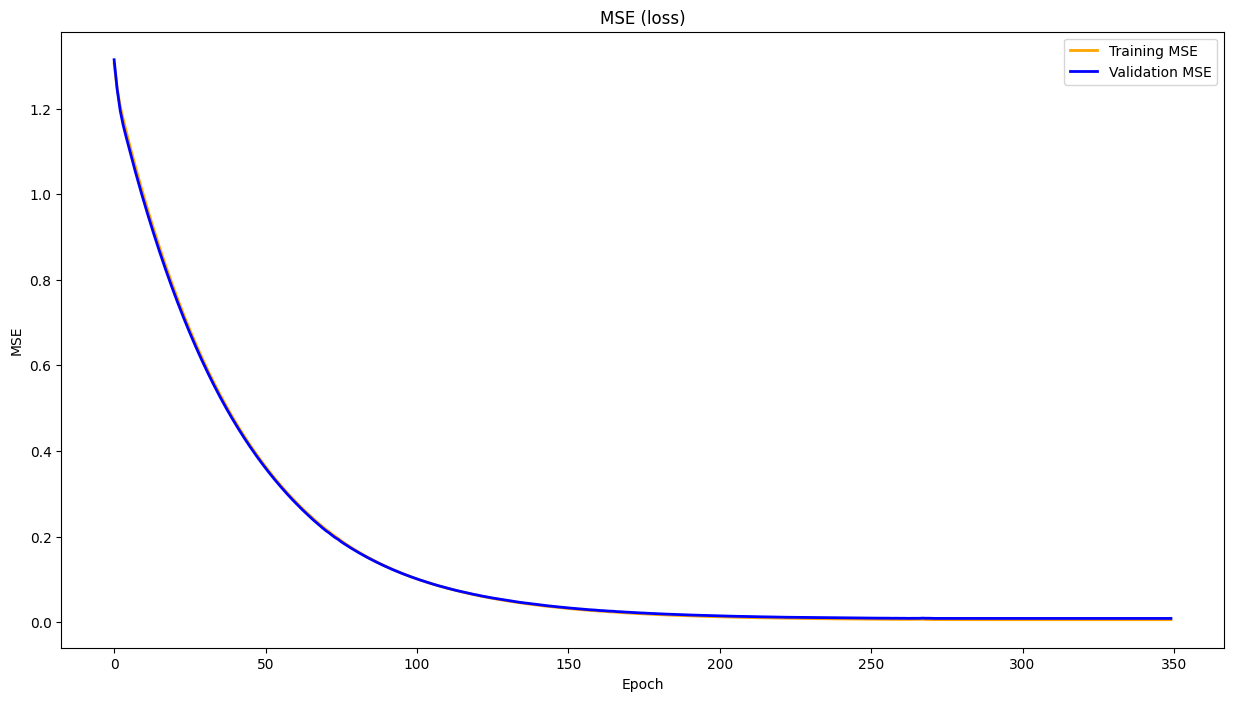

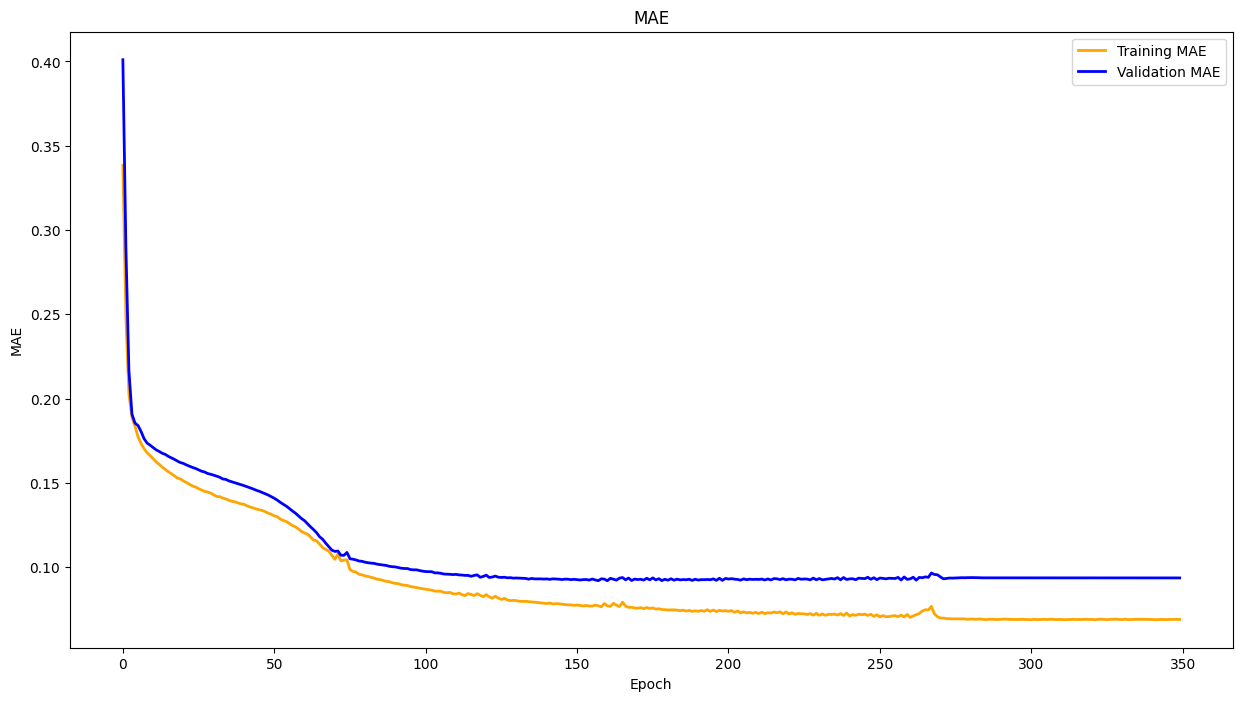

In [10]:
# Visualizing the training and validation loss and MAE
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training MSE', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation MSE', color='blue', linewidth=2, markersize=6)
ax.set_title('MSE (loss)')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['mae'], label='Training MAE', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_mae'], label='Validation MAE', color='blue', linewidth=2, markersize=6)
ax.set_title('MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
ax.legend()

In [ ]:
# Evaluating the model on the test ds 
y_pred = model.predict(X_test_ds)
y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)
y_test_original = target_scaler.inverse_transform(y_test_ds.reshape(-1, y_test_ds.shape[-1])).reshape(y_test_ds.shape)
print(f"Predictions shape: {y_pred_original.shape}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Predictions shape: (2574, 24, 3)


R2 for zone_one: 70.37%
R2 for zone_two: 27.65%
R2 for zone_three: -302.39%


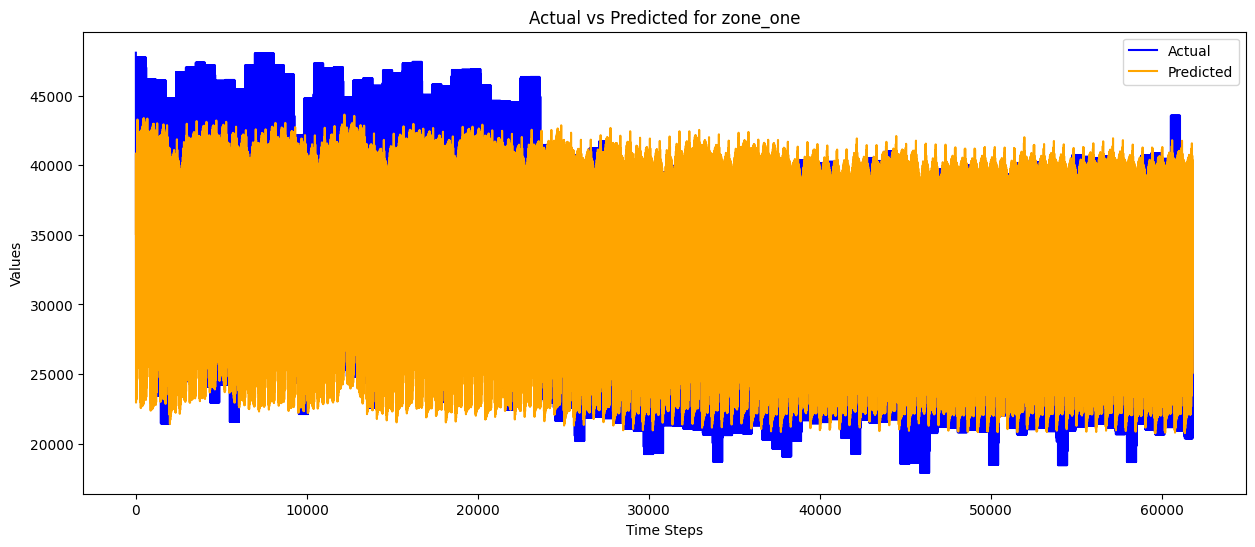

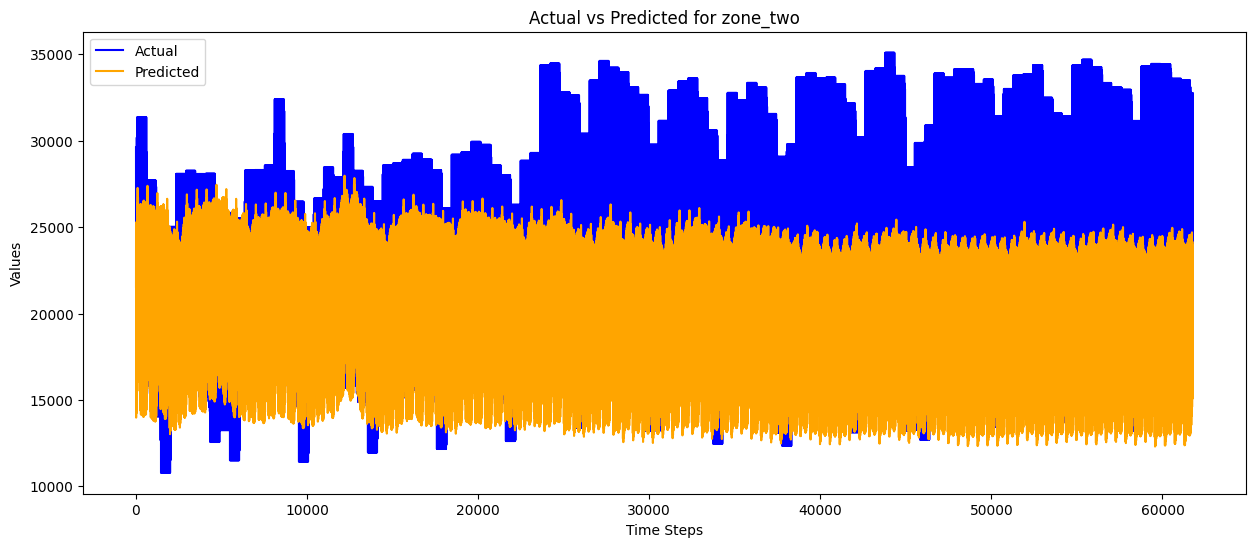

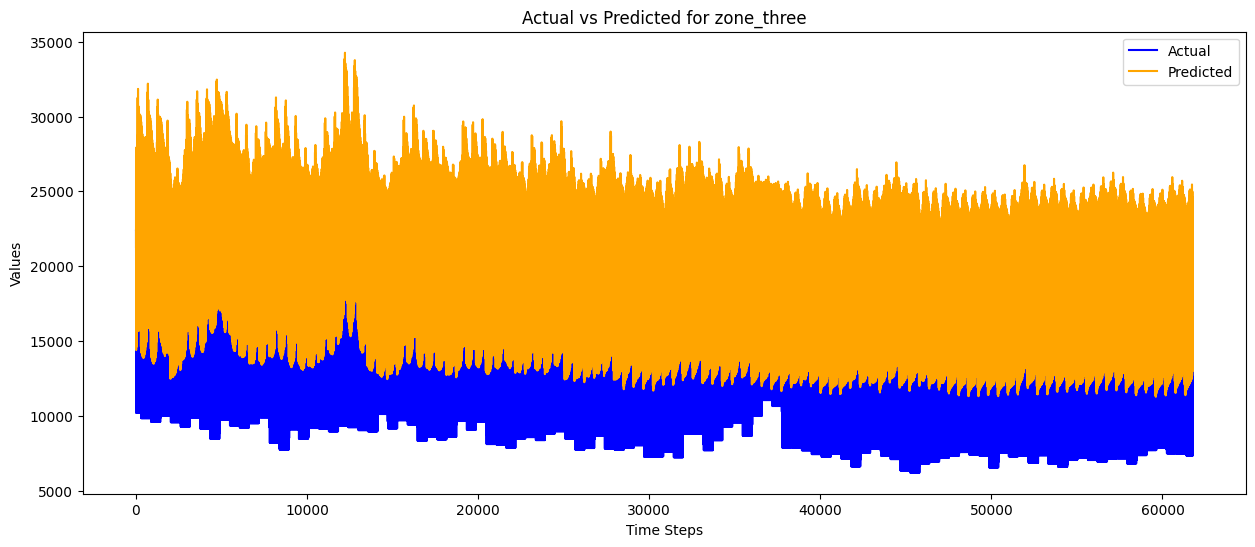

In [ ]:
zones = ['zone_one', 'zone_two', 'zone_three']
for i, zone in enumerate(zones):
    r2_zone = r2_score(y_test_original[:, :, i].reshape(-1), y_pred_original[:, :, i].reshape(-1))
    print(f"R2 for {zone}: {r2_zone*100:.2f}%")

# Compare actual vs predicted 
for i, zone in enumerate(zones):
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_original[:, :, i].reshape(-1), label='Actual', color='blue')
    plt.plot(y_pred_original[:, :, i].reshape(-1), label='Predicted', color='orange')
    plt.title(f'Actual vs Predicted for {        zone}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
# Model has better performance on zone_one, but it is so bad on zone_three. 
# I could try multi head output for this problem.

In [ ]:
# For debugging, I used Grok

In [13]:
# I used these sources:
# https://www.youtube.com/watch?v=kGdbPnMCdOg
# https://medium.com/data-science/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352